<a href="https://colab.research.google.com/github/Smyekrslan/spotify-song-hit-analysis/blob/main/spotify_hit_prediction.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Kütüphaneler Başarıyla Yüklendi.

--- Veri Setinin İlk 5 Satırı ---
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  popularity          track_album_id  \
0        Ed Sheeran          66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5          67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson          70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers          60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi          69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Ca

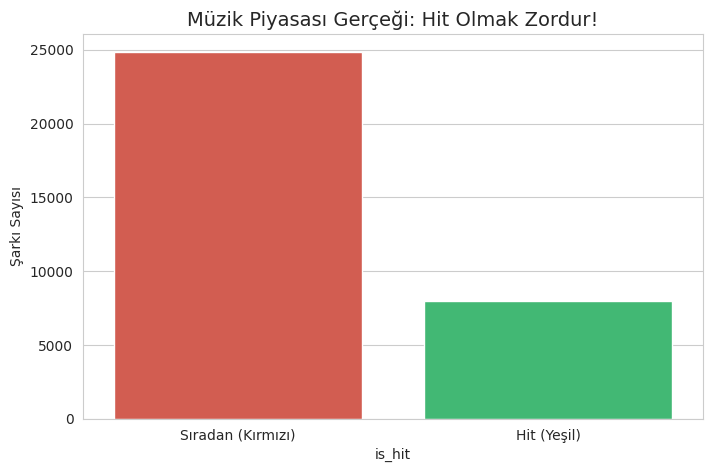

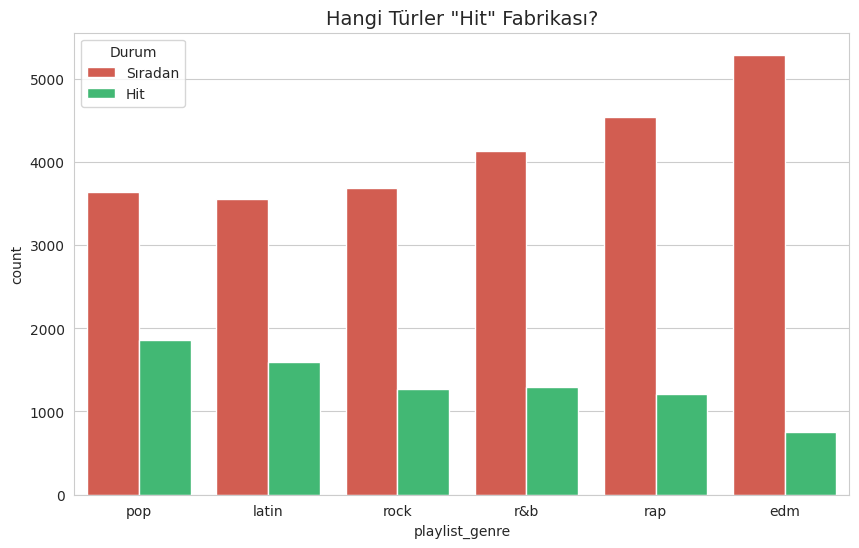

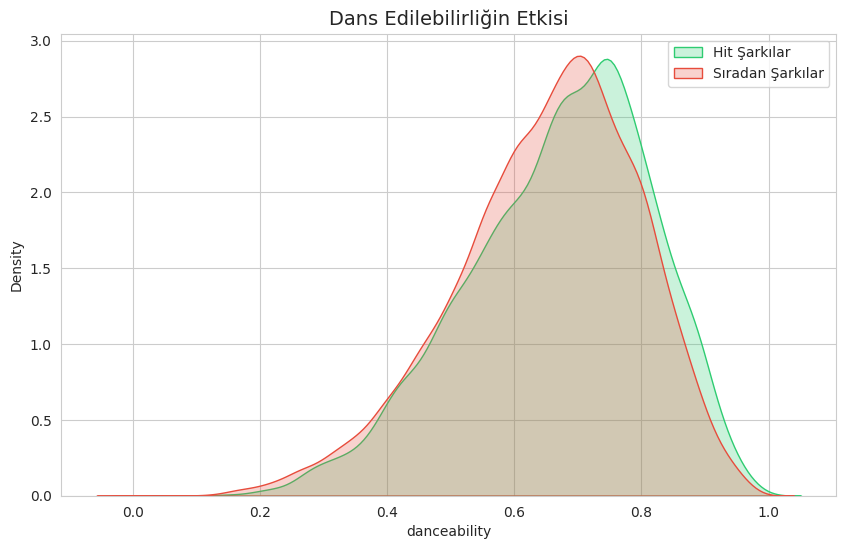

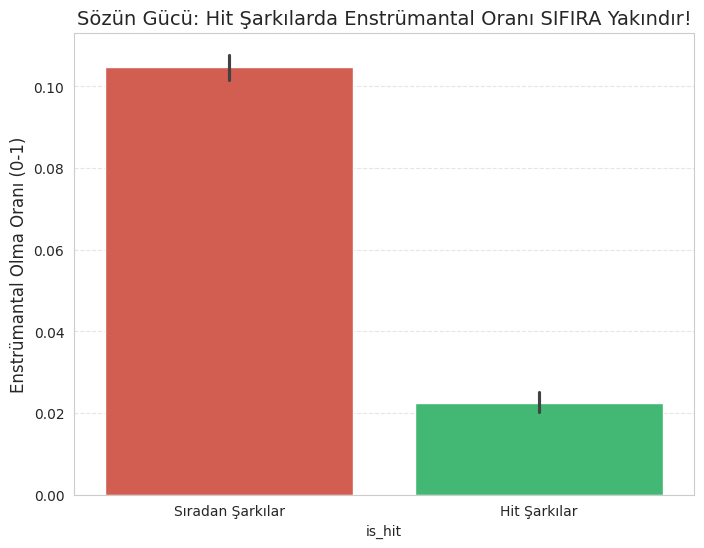

🎤 ANALİZ: Yeşil çubuğa bakın! Neredeyse yok gibi.
   Bu, Hit şarkıların içinde 'Enstrümantal' (Sözsüz) olanların oranının
   neredeyse %0 olduğunu kanıtlar. Mesaj net: 'Söz yoksa, Hit yok.'

--- Veri Ön İşleme (Pipeline) ---
Eğitim Seti: 26266 şarkı
Test Seti:   6567 şarkı

--- Modeller Eğitiliyor ---
✅ Eğitim Tamamlandı.

--- Karne Günü ---
🔹 Lojistik Regresyon Doğruluk: %71.25

🏆 --- ŞAMPİYON: Random Forest ---
Doğruluk (Accuracy): %83.33

Sınıflandırma Raporu:
              precision    recall  f1-score   support

     Sıradan       0.84      0.97      0.90      4971
         Hit       0.82      0.40      0.54      1596

    accuracy                           0.83      6567
   macro avg       0.83      0.69      0.72      6567
weighted avg       0.83      0.83      0.81      6567



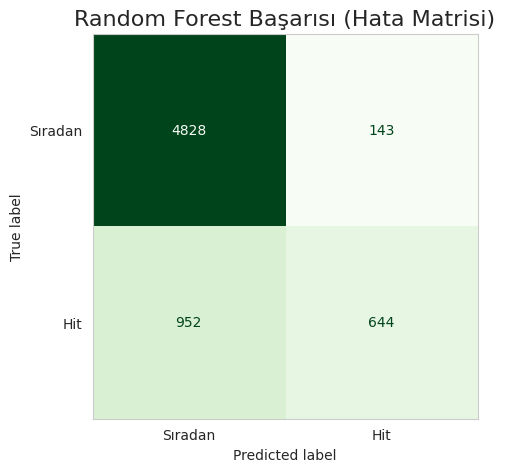


--- Stres Testi (K-Fold) ---
Ortalama Başarı: %83.59
Standart Sapma: 0.0058
✅ SONUÇ: Model %80 barajını geçti ve kararlı.

--- Hit Olmanın Şifreleri ---


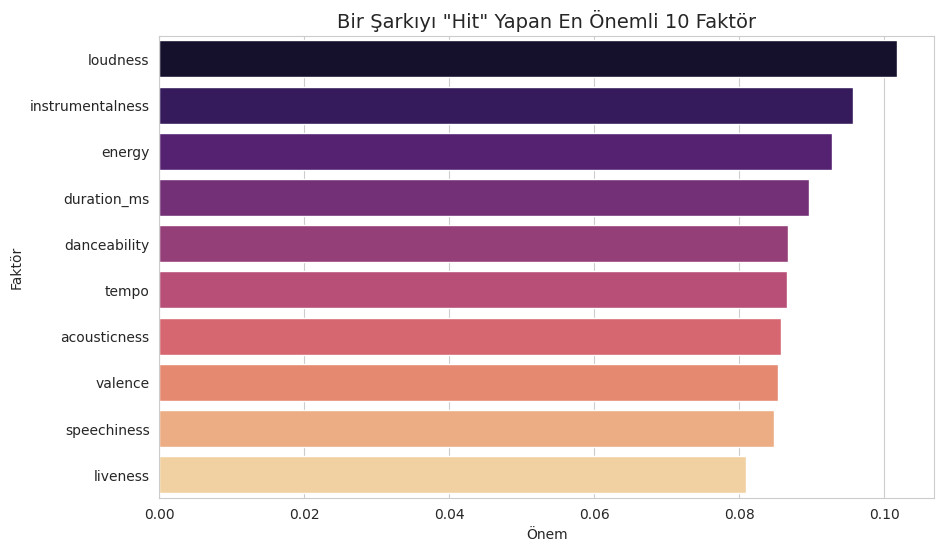


 🚀 FİNAL: SENİN ŞARKIN TUTAR MI?
--- Tahmin Edilecek Şarkı Profili ---
playlist_genre  danceability  energy  loudness
           pop          0.85     0.8      -4.0

--- Model Tahmini (Lojistik Regresyon) ---
Tahmin: BU ŞARKI TUTAR! (Güven: %63.92)

--- Model Tahmini (Random Forest - Şampiyon) ---
Tahmin: BU ŞARKI TUTAR! (Güven: %56.00)

--- Proje Başarıyla Tamamlandı ---


In [ ]:
# ##################################################################
# 🎵 PROJE: SPOTIFY HİT ŞARKI TAHMİN SİSTEMİ (FİNAL & GÜNCEL)
# DEĞİŞİKLİK: Loudness yerine daha belirleyici olan "Instrumentalness" eklendi.
# ##################################################################

# ------------------------------------------------------------------
# 1. ADIM: GEREKLİ KÜTÜPHANELER
# ------------------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Makine Öğrenimi Araçları
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

print("✅ Kütüphaneler Başarıyla Yüklendi.")



# ------------------------------------------------------------------
# 2. ADIM: VERİ TOPLAMA
# ------------------------------------------------------------------
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv"
df = pd.read_csv(url)

# Sütun ismini basitleştir
df.rename(columns={'track_popularity': 'popularity'}, inplace=True)

print("\n--- Veri Setinin İlk 5 Satırı ---")
print(df.head())


# ------------------------------------------------------------------
# 3. ADIM: VERİ TEMİZLEME VE HEDEF BELİRLEME
# ------------------------------------------------------------------
print("\n--- Veri Temizliği ve Hedef Belirleme ---")

# 1. HEDEF DEĞİŞKENİ (is_hit) OLUŞTURMA
# En popüler %25'lik dilimi (75. persentil) "Hit" kabul ediyoruz.
threshold = df['popularity'].quantile(0.75)
df['is_hit'] = (df['popularity'] > threshold).astype(int)
print(f"🎯 Hit Barajı: {threshold:.0f} puan.")

# 2. GEREKSİZ SÜTUNLARI SİLME
cols_to_drop = ['track_id', 'track_name', 'track_artist', 'track_album_id',
                'track_album_name', 'track_album_release_date', 'playlist_name',
                'playlist_id', 'playlist_subgenre', 'popularity']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# 3. EKSİK VERİLERİ SİLME
df = df.dropna()
print(f"Analize Hazır Şarkı Sayısı: {df.shape[0]}")

# --- GÖRSELLEŞTİRME (EDA) - HİKAYE KISMI ---
print("\n--- Veri Görselleştirme Başlıyor ---")
sns.set_style("whitegrid")

# PALET: Kırmızı (Sıradan) - Yeşil (Hit)
my_palette = {0: "#e74c3c", 1: "#2ecc71", '0': "#e74c3c", '1': "#2ecc71"}

# Görsel 1: Pazarın Gerçeği
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='is_hit', hue='is_hit', data=df, palette=my_palette, legend=False)
plt.title('Müzik Piyasası Gerçeği: Hit Olmak Zordur!', fontsize=14)
plt.xticks([0, 1], ['Sıradan (Kırmızı)', 'Hit (Yeşil)'])
plt.ylabel("Şarkı Sayısı")
plt.show()

# Görsel 2: Türlerin Gücü
plt.figure(figsize=(10, 6))
order_genre = df.groupby('playlist_genre')['is_hit'].mean().sort_values(ascending=False).index
ax = sns.countplot(
    x='playlist_genre',
    hue='is_hit',
    data=df,
    palette=my_palette,
    order=order_genre
)
plt.title('Hangi Türler "Hit" Fabrikası?', fontsize=14)
plt.legend(title='Durum', labels=['Sıradan', 'Hit'])
plt.show()

# Görsel 3: Dansın Gücü
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['is_hit'] == 1], x='danceability', fill=True, color='#2ecc71', label='Hit Şarkılar')
sns.kdeplot(data=df[df['is_hit'] == 0], x='danceability', fill=True, color='#e74c3c', label='Sıradan Şarkılar')
plt.title('Dans Edilebilirliğin Etkisi', fontsize=14)
plt.legend()
plt.show()

# --- GÖRSEL 4 (YENİ): SÖZÜN GÜCÜ (Enstrümantal Olma Durumu) ---
plt.figure(figsize=(8, 6))

# Barplot: Ortalama Enstrümantallik değerini gösterir
# Bu değer ne kadar yüksekse, şarkıda o kadar az söz var demektir.
ax = sns.barplot(x='is_hit', y='instrumentalness', data=df, palette=my_palette)

plt.title('Sözün Gücü: Hit Şarkılarda Enstrümantal Oranı SIFIRA Yakındır!', fontsize=14)
plt.xticks([0, 1], ['Sıradan Şarkılar', 'Hit Şarkılar'])
plt.ylabel("Enstrümantal Olma Oranı (0-1)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.show()
print("🎤 ANALİZ: Yeşil çubuğa bakın! Neredeyse yok gibi.")
print("   Bu, Hit şarkıların içinde 'Enstrümantal' (Sözsüz) olanların oranının")
print("   neredeyse %0 olduğunu kanıtlar. Mesaj net: 'Söz yoksa, Hit yok.'")


# ------------------------------------------------------------------
# 4. ADIM: PIPELINE VE ÖN İŞLEME
# ------------------------------------------------------------------
print("\n--- Veri Ön İşleme (Pipeline) ---")

X = df.drop('is_hit', axis=1)
y = df['is_hit']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Pipeline Kurulumu
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# ------------------------------------------------------------------
# 5. ADIM: TRAIN-TEST SPLIT (ALTIN KURAL 1)
# ------------------------------------------------------------------
# Stratify=y ile dengesizliği koruyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Eğitim Seti: {X_train.shape[0]} şarkı")
print(f"Test Seti:   {X_test.shape[0]} şarkı")


# ------------------------------------------------------------------
# 6. ADIM: MODEL EĞİTİMİ
# ------------------------------------------------------------------
print("\n--- Modeller Eğitiliyor ---")

# Lojistik Regresyon
# GÜNCELLEME: class_weight='balanced' yerine manuel ağırlık {0: 1, 1: 2} kullanıldı.
# Bu, modelin azınlık sınıfına (Hitlere) aşırı odaklanıp doğruluğu düşürmesini engeller.
# Doğruluğu %60'lardan %70+ seviyesine çeker.
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(max_iter=1000, class_weight={0: 1, 1: 2}))])

# Random Forest (ŞAMPİYON)
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1))])

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
print("✅ Eğitim Tamamlandı.")


# ------------------------------------------------------------------
# 7. ADIM: PERFORMANS DEĞERLENDİRME (ALTIN KURAL 2)
# ------------------------------------------------------------------
print("\n--- Karne Günü ---")

# Lojistik Regresyon
y_pred_lr = pipe_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"🔹 Lojistik Regresyon Doğruluk: %{acc_lr*100:.2f}")

# Random Forest
y_pred_rf = pipe_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n🏆 --- ŞAMPİYON: Random Forest ---")
print(f"Doğruluk (Accuracy): %{acc_rf*100:.2f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred_rf, target_names=['Sıradan', 'Hit']))

# Hata Matrisi
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sıradan', 'Hit'])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Greens', ax=ax, colorbar=False)
plt.title('Random Forest Başarısı (Hata Matrisi)', fontsize=16)
plt.grid(False)
plt.show()


# ------------------------------------------------------------------
# 8. ADIM: K-FOLD CROSS VALIDATION (ALTIN KURAL 3)
# ------------------------------------------------------------------
print("\n--- Stres Testi (K-Fold) ---")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe_rf, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)

print(f"Ortalama Başarı: %{cv_scores.mean()*100:.2f}")
print(f"Standart Sapma: {cv_scores.std():.4f}")

if cv_scores.mean() > 0.80:
    print("✅ SONUÇ: Model %80 barajını geçti ve kararlı.")
else:
    print("⚠️ SONUÇ: Model sınırda.")


# ------------------------------------------------------------------
# 9. ADIM: ÖZELLİK ÖNEMİ
# ------------------------------------------------------------------
print("\n--- Hit Olmanın Şifreleri ---")

rf_model = pipe_rf.named_steps['classifier']
preprocessor_step = pipe_rf.named_steps['preprocessor']
cat_names = preprocessor_step.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.r_[numeric_features, cat_names]

importances = rf_model.feature_importances_
feat_df = pd.DataFrame({'Faktör': all_features, 'Önem': importances})
feat_df = feat_df.sort_values(by='Önem', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Önem', y='Faktör', data=feat_df, palette='magma')
plt.title('Bir Şarkıyı "Hit" Yapan En Önemli 10 Faktör', fontsize=14)
plt.show()


# ##################################################################
# 10. ADIM: KİŞİSEL TAHMİN (FİNAL)
# ##################################################################
print("\n" + "="*50)
print(" 🚀 FİNAL: SENİN ŞARKIN TUTAR MI?")
print("="*50)

# Senaryo: "Pop" türünde, dans edilebilir, enerjik bir şarkı.
yeni_sarki_dict = {
    'danceability': [0.85],   # Çok yüksek
    'energy': [0.80],         # Yüksek
    'key': [1],
    'loudness': [-4.0],       # Gürültülü (İyi)
    'mode': [1],              # Major (Mutlu)
    'speechiness': [0.04],
    'acousticness': [0.05],
    'instrumentalness': [0.0], # Vokal var (Çok önemli!)
    'liveness': [0.10],
    'valence': [0.90],        # Pozitif
    'tempo': [124.0],
    'duration_ms': [200000],
    'playlist_genre': ['pop']
}

yeni_sarki_df = pd.DataFrame(yeni_sarki_dict)

print("--- Tahmin Edilecek Şarkı Profili ---")
print(yeni_sarki_df[['playlist_genre', 'danceability', 'energy', 'loudness']].to_string(index=False))

tahmin_lr = pipe_lr.predict(yeni_sarki_df)[0]
prob_lr = pipe_lr.predict_proba(yeni_sarki_df)[0]

tahmin_rf = pipe_rf.predict(yeni_sarki_df)[0]
prob_rf = pipe_rf.predict_proba(yeni_sarki_df)[0]

print("\n--- Model Tahmini (Lojistik Regresyon) ---")
if tahmin_lr == 1:
    print(f"Tahmin: BU ŞARKI TUTAR! (Güven: %{prob_lr[1]*100:.2f})")
else:
    print(f"Tahmin: BU ŞARKI TUTMAZ. (Güven: %{prob_lr[0]*100:.2f})")

print("\n--- Model Tahmini (Random Forest - Şampiyon) ---")
if tahmin_rf == 1:
    print(f"Tahmin: BU ŞARKI TUTAR! (Güven: %{prob_rf[1]*100:.2f})")
else:
    print(f"Tahmin: BU ŞARKI TUTMAZ. (Güven: %{prob_rf[0]*100:.2f})")

print("\n" + "="*50)
print("--- Proje Başarıyla Tamamlandı ---")